In [2]:
import sys  
sys.path.insert(0, './codes')
from numpy import (pi,e,cos,sin,tan,linspace,arange,sqrt,array,shape,reshape,zeros,ones,)
import sys
from tqdm.notebook import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import itertools
from math import *
from timeit import default_timer as timer
from pade_func import pade_analytic_continuation
#### NOTE: hbar and k_B are equal to 1

# Functions

Hubbard class is created to avoid having too many variables. The class simply contains almos every information and we can call and change it whenever we want. The class takes $(U,T)$ adn $\textit{params}$ which includes $[N_{\omega_n},d\tau, \text{i.c.}]$ where i.c. is either metallic or insulating initial condition. For most of the calculations, the optimal parameters I found are:

$N_{\omega_n}=300\\$
$d\tau=5\times10^{-3}$

In [32]:
class Hubbard:
    """Hubbard model. When created, it initializes Σloc, iωn, Gloc, mu=0.
    'M': metallic initial cond. ---> Σloc=0
    'I': insulating initial cond. ---> Σloc=-1/iωn
    when inside the DMFT loop, everytime we have a new Σimp=Σloc, we
    update the configuration by calling self.update(Σimp). This is useful when we
    want to plot A(ω) for a specific (U,T).
    """
    from pade_func import pade_analytic_continuation
    def __init__(self, U, T, params):
        self.U = U
        self.T = T
        self.beta = 1./T
        self.N_iomega=params[0]
        self.omega_n=pi/self.beta*( 2 * array(range(-N_iomega//2,N_iomega//2)) + 1 )
        #self.omega_n=pi/self.beta*( 2 * array(range(0,N_iomega)) + 1 )
        
        self.mu=0
        self.cond=params[2]
        self.dtau=params[1]
        self.sigma_loc=self._get_self_energy() #get initial Σ according to self.cond (metallic or insulating)
        
        self.Gloc=get_Gloc(self.omega_n,self.sigma_loc,self.mu)
        self.emin=-10;self.emax=10;self.energy=linspace(self.emin,self.emax,1000)
            
    def _get_self_energy(self):
        """Returns initial condition (metallic or insulator), only called once for the initiliaztion"""
        if self.cond=='I':
            self.sigma_loc = -1/(1j*self.omega_n)
        if self.cond=='M':
            self.sigma_loc = zeros(len(self.omega_n))
        return self.sigma_loc
    
    
    def plot_spectrum(self):
        "do analytic continuation: G(iωn)---> G(ω+iη) and plot A(ω)"
        GF = pade_analytic_continuation(wnn=self.omega_n,nw_out=len(self.energy), emin=self.emin, emax=self.emax, gff=self.Gloc)[0]
        A=-GF.imag/pi
        fig, ax = plt.subplots(figsize=(12,6), nrows=1, ncols=1)
        plt.rcParams['font.size'] = 20
        plt.rcParams['font.family'] = 'sans-serif' #TODO: change to Helvetica?
        plt.rcParams['font.style'] = 'normal'
        plt.rcParams['xtick.labelsize']=15
        plt.rcParams['ytick.labelsize']=15
        plt.plot(self.energy, A,'k')
        #plt.plot(self.energy[energy>0], A[self.energy<0][::-1],'r')
        plt.ylim(0,0.5)
        plt.xlabel(r'$\omega$')
        plt.ylabel(r'$A(\omega)$')
        plt.title(f'Spectrum for U={self.U:.2f}, T={self.T:.3f}')
        plt.plot()    
        
    def update(self,new_sigma):
        """after IPT, update the configuration with new Σimp. This changes the Σloc, Gloc and 
        the chemical potential which ensures µ-Re(Σloc)=0 which means we are at half filling
        (Re(Σloc) is constant).
        """
        self.sigma_loc=new_sigma
        self.mu=(self.sigma_loc[-1]).real #µ-Re(Σloc)=0
        self.Gloc=get_Gloc(self.omega_n,self.sigma_loc,self.mu)
    

def dos_bethe (omega, D):
    '''
    density of states of a Bethe lattice with infinite connectivity 
    (from the analytical expression of the non interacting GF)

    input:      omega       real frequency/energy 
                D           bandwidth, the density of states is non zero for |omega|<D

    output:     rho(omega)  densiy of states, rho(w)=2*sqrt(D^2-w^2)/pi*D^2
    '''

    return np.sqrt(D**2-omega**2)*2/(np.pi*D**2)

def my_fft(G_iw, tau, omega_n): # freq to imag. time
    '''
    Fourier transform of a function G(i*omega_n) where i*omega_n are Matzubara frequencies
    (needed to perform the Iterative Perturbation Theory Step)
    
    input:      func        G(i*omega_n): function of i*omega (Matzubara frequencies)
                beta        inverse temperature
                tau         imaginary time        

    output:     G(tau)      function of the imaginary time (tau), G(tau)=(1/beta)* sum_(w_n)  (e^i*w_n*tau)*G(i*omega_n)
    '''
    
    #nn = np.linspace(start=0, stop=N_iomega, num=N_iomega, dtype=int)
    #matz_frequencies = np.pi*(1/beta) * (2*nn + 1)
    #domega=(matz_frequencies[-1]-matz_frequencies[0])/beta
    
    G_iw_prime = G_iw - 1/(1j*omega_n)
    exponential_iw = np.exp(np.inner(-1j*omega_n[:,np.newaxis],tau[:,np.newaxis]))
    
    G_iw_prime=G_iw_prime[omega_n > 0]
    exponential_iw = exponential_iw[omega_n > 0]
    intg1=np.real(exponential_iw*G_iw_prime[:,np.newaxis]) 
    
    #intg2=
    beta=tau[-1]+(tau[-1]-tau[0])/len(tau)
    ans1=np.sum(intg1,axis=0)*2/beta

    return  ans1 - np.sign(tau)/2 

def my_ifft(G_tau, tau, omega_n): # imag. time to freq
    '''
    Inverse Furier transform of a function G(tau) to G(iwn) where iwn are Matzubara frequencies
    (needed to perform the Iterative Perturbation Theory Step)
    
    input:      func        G(i*omega_n): function of i*omega (Matzubara frequencies)
                beta        inverse temperature
                tau         imaginary time        

    output:     G(iwn)      function of the matsubara frequencies
    '''
    exponential_tau = np.exp(np.inner(tau[:,np.newaxis],1j*omega_n[:,np.newaxis]))

    return  np.sum(exponential_tau * G_tau[:,np.newaxis],axis=0) * (tau[-1]-tau[0])/len(tau)

def IPT_solver(G0,config,dt=1e-3):
    '''
    finds the self energy of the auxiliary Anderson impurtity model Sigma_imp
    from this it evaluates also the interacting Green's function of the auxiliary system (G coursive)

    input:      impurity_non_int_greens_func        G_0 (iomega) coursive: non interacting Green's function of the auxiliary system
                                                                           encoded in step (3) and evaluated on Matzubara frequency
                iomega                              Matzubara frequency i*omega_n
                U                                   impurity interaction
                beta                                inverse temperature  

    output:     impurity_self_energy(iomega)        self energy of the auxiliary system    Sigma_imp(iw)=U/2 + U^2 * int_0^beta d(tau) (e^i*w_n*tau) * G_0^shifted(tau)^3
                                                                                           knowing G_0^shifted(iw)= (G_0(iw)^-1  - U/2)^-1     where all the G are coursive
                impurity_int_greens_func(iomega)    interacting GF of the auxiliary system   G(iw) = (  G_0(iw)^-1 - Sigma_imp(iw)  )^-1          where all the G are coursive

    note: this fucntion uses the function fourier_trans_to_imag_time() to convert G_0^shifted(iw) coursive in imaginary time
    '''
    omega_n=config.omega_n; beta=config.beta; U=config.U
    # I calculate G_0_shifted(iw) as a function of iomega
    G0_shifted = 1 / ( (1/G0) - U/2 )

    # I calculate the fourier transform G_0_shifted(tau)
    tau=np.arange(0,beta,config.dtau)
    G0_tau_shifted_ = my_fft(G0_shifted, tau, omega_n)
    # I calculate the integral
    G0_tau_cube=G0_tau_shifted_**3
    integral = my_ifft(G0_tau_cube, tau, omega_n)  

    # I get Sigma_imp and the interacting GF of the impurity
    Sigma_imp = U/2 + U**2  * integral

    #G_0_iw = impurity_non_int_greens_func
    G_imp = 1 / ( 1/G0 - Sigma_imp )
    return Sigma_imp

def get_Gloc(omega_n,sigma_loc,mu):
    '''
    get local interacting green's function
    input:    rho           vector with density of states evaluated at all the energy steps of the integral
              omega_n       vector with matzubara frequencies form O to N_matz_freq
              eps           values of energies of the integration = eps=np.linspace(-D,D,len(omega_n))
    '''
    D=2;
    eps=np.linspace(-D,D,1000)
    rho=dos_bethe(eps,D)
    Gloc=zeros(len(omega_n))+0*1j
    d_eps=(eps[-1]-eps[0])/len(eps)
    for i in range(len(eps)):
        Gloc += rho[i]/(1j*omega_n+mu-eps[i]-sigma_loc)*d_eps
    return Gloc

def do_DMFT_loop(config,Gtol=1e-7,show_info=False):
    "perform DMFT loop until convergence"
    #pbar = tqdm_notebook(total=100)
    c=0
    dist=0.1
    start = timer()
    while dist>Gtol:
        """dt and N_iomega must be adjusted adaptively"""
        # step 2: get local GF
        #G_loc=config.Gloc
        #print(config.Gloc[0],config.sigma_loc[0],config.mu)
        #config.Gloc=get_Gloc(config.omega_n,config.sigma_loc,config.mu)
        # step 3: obtain the impurity GF
        G0= 1/( (1/config.Gloc) + config.sigma_loc )

        # step 4: solve impurity model
        Sigma_imp= IPT_solver(G0,config,dt=config.dtau)
        
        G_loc_new=get_Gloc(config.omega_n,Sigma_imp,config.U/2)#config.mu)
        #G_imp = 1 / ( 1/G0 - Sigma_imp )
        # step 5:
        if show_info:
            if np.mod(c,5)==0:
                sys.stdout.flush()
                sys.stdout.write(f'converging (U,T)=({round(config.U,2)}, {round(config.T,3)}). iteration {c}: distance = {dist:.2e}\r')
                #pbar.set_description(f"iteration = {c:d}, with dist. {dist:.2e}")
            
        #dist=np.abs(np.sum(Sigma_loc - Sigma_imp))
        dist=np.abs(np.sum(config.Gloc - G_loc_new))
        
        #updating the configuration
        config.update(Sigma_imp)
        
        #config.sigma_loc = alpha*Sigma_imp+(1-alpha)*config.sigma_loc
        #config.mu=(config.sigma_loc[-1]).real
        
        

        c += 1
        #G_loc=G_imp
    
    end = timer()
    elapsed=end - start
    if elapsed<60:print(f'Converged (U,T)=({round(config.U,2)}, {round(config.T,3)}). Elapsed time: {round(elapsed,2)} seconds.' )
    else:print(f'Converged (U,T)=({round(config.U,2)}, {round(config.T,3)}). Elapsed time: {round(elapsed/60,2)} minutes.' )
        
def do_phase_diagram(params,Ulist,Tlist):
    #for U,T in itertools.product(Ulist, Tlist):
    for T in Tlist:
        #dtau=0.1*1/params[0]/T
        #params=[params[0],dtau,params[2]]
        #we start from an initial condition for U here
        config=Hubbard(Ulist[0],T,params)
        for U in Ulist:
            config.U = U
            strU=str(round(U,2));strT=str(round(T,3))
            if U==Ulist[0]:#load the latest initial condition
                try:
                    sigma_load=np.genfromtxt(f'sigma_files/dmft_M_U{strU[0]}p{strU[2:]}_T{strT[0]}p{strT[2:]}.dat',dtype=np.complex128)
                    config.update(sigma_load)
                    continue
                except:
                    pass
            
            do_DMFT_loop(config,Gtol=1e-5,show_info=True)
            
            
            #write the converged sigma which is going to be the initial condition for the next U.
            #important remark is to know from which initial condition we have started: metallic (M) or insulating (I)
            #np.savetxt(f'sigma_files/dmft_{config.cond}_U{strU[0]}p{strU[2:]}_T{strT[0]}p{strT[2:]}.dat',config.sigma_loc)
            

# Perform the Phase-Diagram calculation

There is a problem here: as we get closer to the critical point (~4 I guess), the calculation time diverges around 3.4 (you can see below) and the distance starts increasing instead of decreasing. This is still the case regardless how small we increment $U$ towards $U_c$. This means we have a problem but I can't figure out.

In [12]:
N_iomega=100
dtau=5e-3
params=[N_iomega,dtau,'M']
#Ulist=np.concatenate( (arange(0.1,1.5,0.2),arange(1.5,2.5,0.02),arange(2.5,3.5,0.1)),axis=None )
Ulist=np.concatenate( (arange(1.3,3.4,0.2),arange(3.4,5.1,0.02),arange(5.1,7,0.1)),axis=None )
#Ulist=np.concatenate( (arange(1.3,4.9,0.2),arange(4.9,6.9,0.05),arange(6.9,9,0.1)),axis=None )
#Ulist=np.concatenate( (arange(2.1,4.3,0.2),arange(4.3,6,0.1),arange(6.9,9,0.2)),axis=None )
#Tlist=arange(0.005,0.3,0.005)
Tlist=arange(0.025,0.3,0.005)
do_phase_diagram(params,Ulist,Tlist)

Converged (U,T)=(1.3, 0.025). Elapsed time: 0.89 seconds.56e-03
Converged (U,T)=(1.5, 0.025). Elapsed time: 0.88 seconds.33e-04
Converged (U,T)=(1.7, 0.025). Elapsed time: 0.98 seconds.39e-03
Converged (U,T)=(1.9, 0.025). Elapsed time: 1.21 seconds..22e-05
Converged (U,T)=(2.1, 0.025). Elapsed time: 1.34 seconds..92e-05
Converged (U,T)=(2.3, 0.025). Elapsed time: 1.63 seconds..26e-04
Converged (U,T)=(2.5, 0.025). Elapsed time: 1.99 seconds..98e-05
Converged (U,T)=(2.7, 0.025). Elapsed time: 2.53 seconds..22e-05
Converged (U,T)=(2.9, 0.025). Elapsed time: 3.46 seconds..35e-05
Converged (U,T)=(3.1, 0.025). Elapsed time: 5.54 seconds..49e-05
Converged (U,T)=(3.3, 0.025). Elapsed time: 14.72 seconds..12e-05
Converged (U,T)=(3.4, 0.025). Elapsed time: 4.36 minutes. 1.01e-05


KeyboardInterrupt: 

# calculate $A(\omega)$ for a specific $(U,T)$

be careful to stay close to the initial conditions (metallic or insulating) otherwise results get weird (since we actually need to go the desired $(U,T)$ slowly)

Converged (U,T)=(1.22, 0.025). Elapsed time: 2.71 seconds.74e-03


(0.0, 0.5)

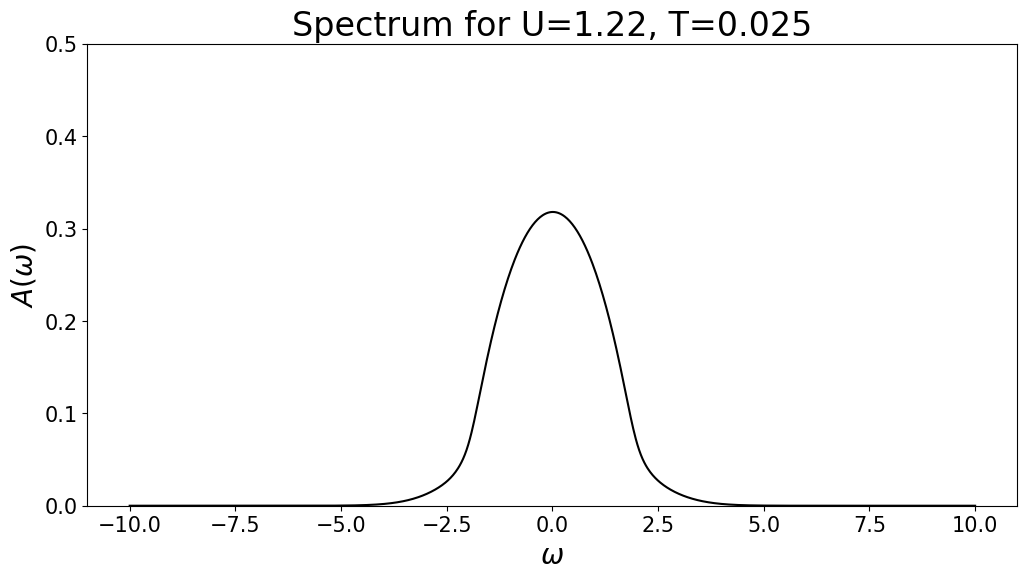

In [33]:
U=1.22; T=0.025; beta=1/T
N_iomega=300
#config.U=U
#dtau=0.1*beta/N_iomega#
dtau=5e-3
params=[N_iomega,dtau,'M']
config=Hubbard(U,T,params)
do_DMFT_loop(config,Gtol=1e-5,show_info=True)
config.plot_spectrum()
#plt.plot(np.linspace(-10,10,1000), dos_bethe(np.linspace(-10,10,1000),1),'r')
plt.ylim(0,0.5)

In [4]:
strU=str(round(U,2));strT=str(round(T,3))
np.savetxt(f'sigma_files/dmft_{config.cond}_U{strU[0]}p{strU[2:]}_T{strT[0]}p{strT[2:]}.dat',config.sigma_loc)

NameError: name 'U' is not defined

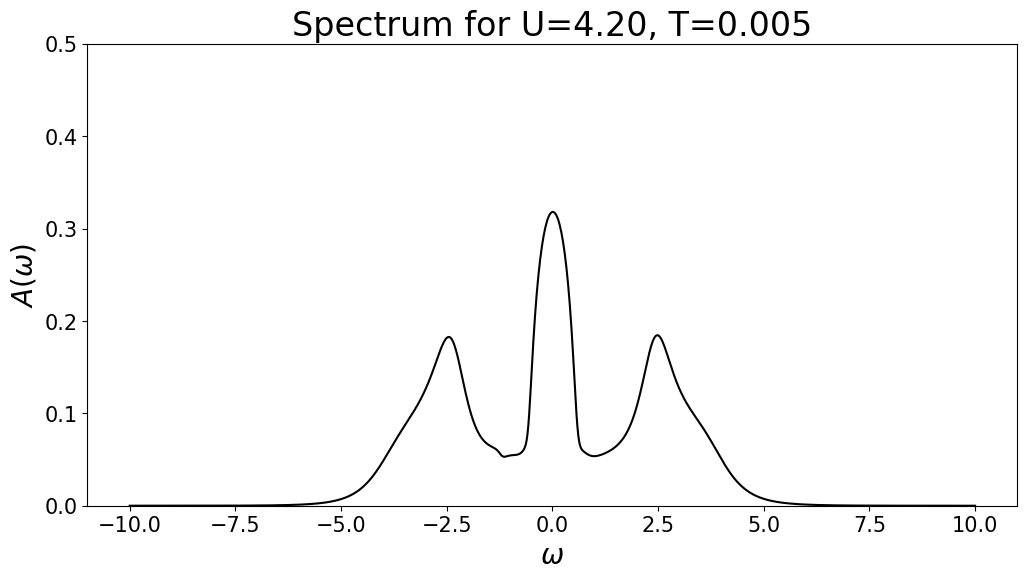

In [94]:
U=4.20; #dtau=5e-3
N_iomega=300; params=[N_iomega,dtau,'M']
config2=Hubbard(U,T,params)
strU=str(round(U,2));strT=str(round(T,3))
#config.U=3.1
sigma=np.genfromtxt(f'sigma_files/dmft_M_U{strU[0]}p{strU[2:]}_T{strT[0]}p{strT[2:]}.dat',dtype=np.complex128)
config2.update(sigma)
#config.mu=mu
config2.plot_spectrum()

In [104]:
U=4.20; T=0.005; beta=1/T
N_iomega=300
config2.U=U
dtau=0.1*beta/N_iomega#
params=[N_iomega,dtau,'M']
#config=Hubbard(U,T,params)
do_DMFT_loop(config2,Gtol=1e-5,show_info=True)
config2.plot_spectrum()

KeyboardInterrupt: 

In [ ]:
strU=str(round(U,2));strT=str(round(T,3))
np.savetxt(f'sigma_files/dmft_{config2.cond}_U{strU[0]}p{strU[2:]}_T{strT[0]}p{strT[2:]}.dat',config2.sigma_loc)

Converged (U,T)=(5.1, 0.05). Elapsed time: 1.12 minutes.2.30e-05


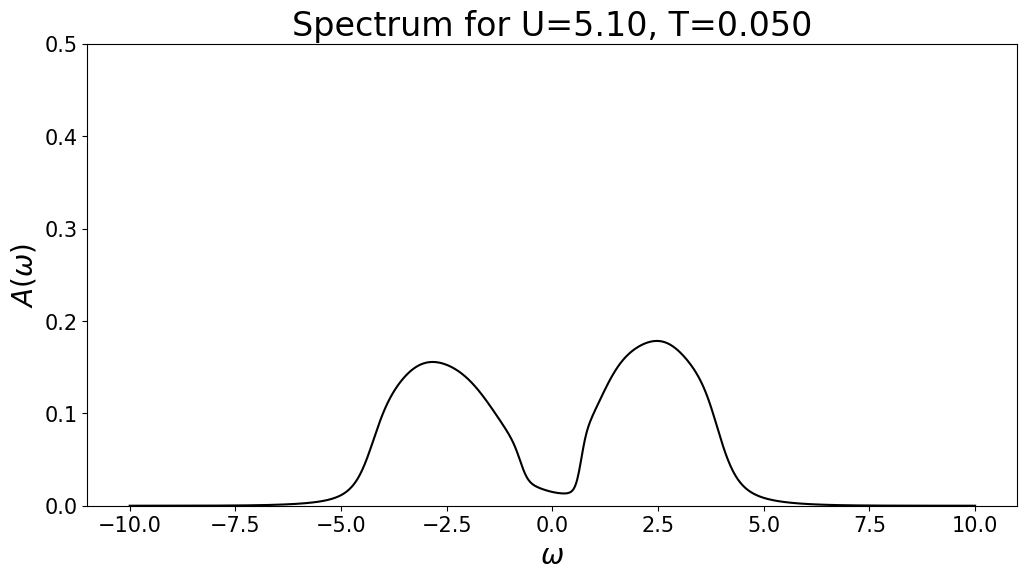

In [142]:
U=5.1; T=0.05; beta=1/T#dtau=5e-3
dtau=0.1*beta/N_iomega#
config3.U=U
N_iomega=300; params=[N_iomega,dtau,'I']
#config3=Hubbard(U,T,params)
do_DMFT_loop(config3,Gtol=1e-5,show_info=True)
strU=str(round(U,2));strT=str(round(T,3))
#config.U=3.1
#sigma=np.genfromtxt(f'sigma_files/dmft_M_U{strU[0]}p{strU[2:]}_T{strT[0]}p{strT[2:]}.dat',dtype=np.complex128)
#config3.update(sigma)
#config.mu=mu
config3.plot_spectrum()

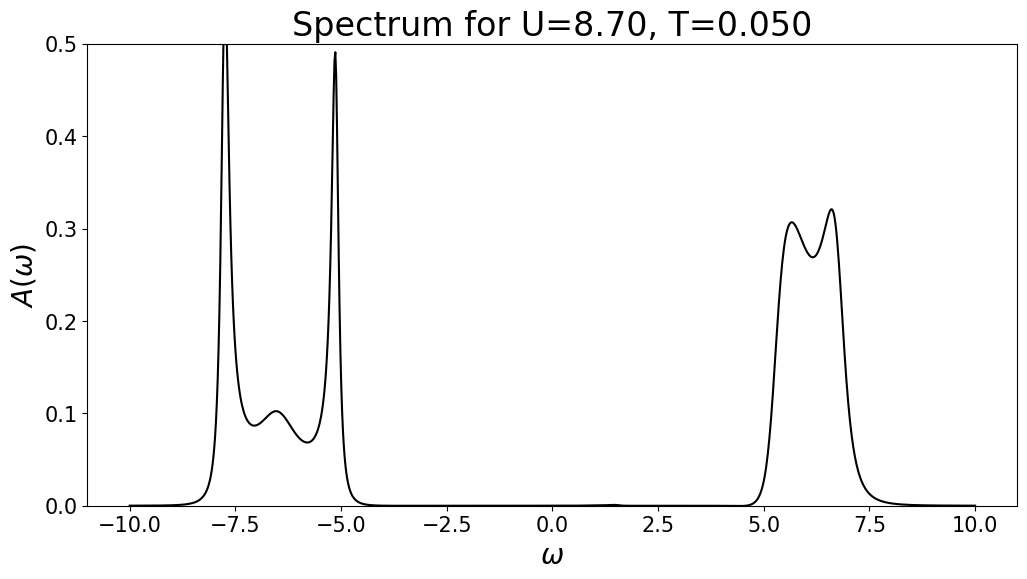

In [121]:
config3.plot_spectrum()